# Optional Parameterization

This example uses all optional parameters of the methods which are explained in the [API documentation](https://doc.zahner.de/zahner_analysis/). But only the usage is shown, the parameters are explained in the linked documentation.

In [1]:
from zahner_analysis.analysis_tools.eis_fitting import EisFitting, EisFittingPlotter
from zahner_analysis.file_import.impedance_model_import import IsfxModelImport
from zahner_analysis.file_import.ism_import import IsmImport
from zahner_analysis.analysis_tools.analysis_connection import AnalysisConnection
from zahner_analysis.plotting.impedance_plot import bodePlotter
import matplotlib.pyplot as plt

# AnalysisConnection Class

In the standard configuration it is checked if a [Zahner Analysis](https://zahner.de/products-details/software/Zahner-Analysis) with server is running, if this is not the case the Zahner Analysis is automatically started and automatically closed again.

This behavior can be changed with the optional parameters, which are explained in the API documentation of the [AnalysisConnection](https://doc.zahner.de/zahner_analysis/analysis_connection.html#zahner_analysis.analysis_tools.analysis_connection.AnalysisConnection) class.

In [2]:
if __name__ == "__main__":
    conn = AnalysisConnection(
        ip="127.0.0.1",
        port=8085,
        tryToConnect=True,
        tryToStart=True,
        onlineCheckUrl="/id",
        apiKey="MyKeyToPreventSomeoneElseRemotelyUsingMyAnalysis",
        buffer_size=32768,
        keep_jobs=10,
        timeToWaitForOnline=10,
        keepOpen=True,
    )

The constructor is then used to pass the [AnalysisConnection](https://doc.zahner.de/zahner_analysis/analysis_connection.html#zahner_analysis.analysis_tools.analysis_connection.AnalysisConnection) object created in the previous step to the [EisFitting](https://doc.zahner.de/zahner_analysis/analyze/index.html#zahner_analysis.analysis_tools.eis_fitting.EisFitting) class.

In [3]:
fitting = EisFitting(conn)

# Optional Fit and Simulation Parameters

With optional dictionaries you can edit the behavior of the fit and the simulation. The parameters are explained in tables in the documentation of the [fit()](https://doc.zahner.de/zahner_analysis/analyze/index.html#zahner_analysis.analysis_tools.eis_fitting.EisFitting.fit) command.

It is also possible to set only single required parameters in the dictionary. The *Smoothness* parameter can be easily determined with the [Zahner Analysis GUI](https://zahner.de/products-details/software/Zahner-Analysis).

In [4]:
fitParams = {
    "UpperFrequencyLimit": 100000,
    "LowerFrequencyLimit": 1e-6,
    "DataSource": "zhit",  # "original", "smoothed" or "zhit"
    "Smoothness": 0.0002,
    "NumberOfSamples": 20,
}

There is a separate dictionary for processing the simulation of the model. By default, the frequency range of the measurement data is used for the simulation.

However, it is possible to simulate the model over a different frequency range, as in this example, down to 1 µHz.

In [5]:
simulationParams = {
    "UpperFrequencyLimit": 10e3,
    "LowerFrequencyLimit": 1e-6,
    "NumberOfSamples": 150,
}

# Simulate the Model

The model can be [simulated](https://doc.zahner.de/zahner_analysis/analyze/index.html#zahner_analysis.analysis_tools.eis_fitting.EisFitting.simulate) with its start values for the fit.

Then the impedance spectras are plotted with the [bodePlotter](https://doc.zahner.de/zahner_analysis/plotting/index.html#zahner_analysis.plotting.impedance_plot.bodePlotter) function. This function and [nyquistPlotter](https://doc.zahner.de/zahner_analysis/plotting/index.html#zahner_analysis.plotting.impedance_plot.bodePlotter) have been developed for the easy display of impedance spectra in the plotting style of Zahner Analysis.

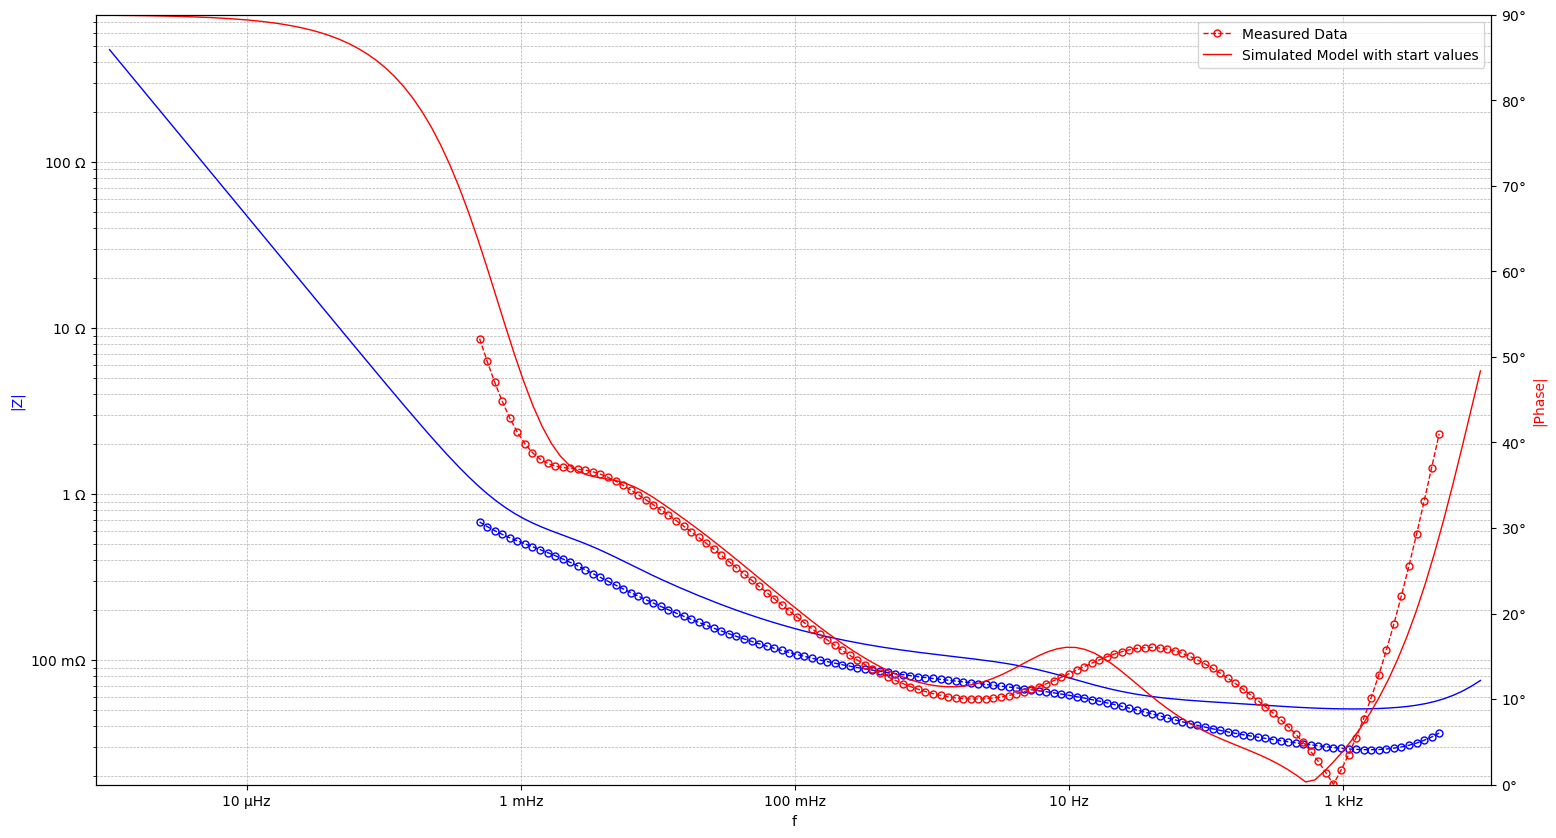

In [6]:
impedanceCircuitModel = IsfxModelImport("li-ion-model.isfx")
impedanceData = IsmImport("li-ion-battery.ism")

simulatedData = fitting.simulate(impedanceCircuitModel, simulationParams)

(fig1, (impedanceAxis1, phaseAxis1)) = bodePlotter(impedanceObject=impedanceData)
(fig1, (impedanceAxis1, phaseAxis1)) = bodePlotter(
    (impedanceAxis1, phaseAxis1),
    impedanceObject=simulatedData,
    argsImpedanceAxis={"linestyle": "solid", "marker": None},
    argsPhaseAxis={"linestyle": "solid", "marker": None},
)
phaseAxis1.legend(["Measured Data", "Simulated Model with start values"])
fig1.set_size_inches(18, 10)
plt.show()

foldername = "fit_result"

fig1.savefig(f"{foldername}/bode_not_fitted.png")

# Fit the Model to the Data

The model is then fitted to the data. For this, the [optional dictionaries](https://doc.zahner.de/zahner_analysis/analyze/index.html?highlight=fit#zahner_analysis.analysis_tools.eis_fitting.EisFitting.fit) explained in the previous are passed to change the behavior of the fitter and the simulation.

The optional parameters of the [save()](https://doc.zahner.de/zahner_analysis/analyze/index.html#zahner_analysis.analysis_tools.eis_fitting.EisFittingResult.save) function can be used to determine what is saved under which filename.

In [7]:
fittingResult = fitting.fit(
    impedanceCircuitModel,
    impedanceData,
    fitParams=fitParams,
    simulationParams=simulationParams,
)

print(fittingResult)

fittingResult.save(
    path="",
    foldername=foldername,
    exist_ok=True,
    saveFitResultJson=True,
    saveFittedModel=True,
    saveFittedSimulatedSamples=True,
    saveFitInputSamples=True,
    fitResultJsonFilename="fit_result.json",
    fittedModelFilename="fitted.isfx",
    fittedSimulatedDataFilename="fitted_simulated.ism",
    fitInputDataFilename="fit_samples.ism",
)

Fitted Model:
finite-diffusion : FI0
      W:  4.058e-02 Ωs^(-½)  fixed: False
      k:  1.397e-03 1/s      fixed: False
constant-phase-element : CPE0
   C_eq:  6.688e-02 F        fixed: False
      α:  7.347e-01          fixed: False
 f_norm:  1.000e+03 Hz       fixed: True
capacitor : C0
      C:  5.043e-02 F        fixed: False
resistor : R0
      R:  3.576e-03 Ω        fixed: False
resistor : R1
      R:  2.682e-02 Ω        fixed: False
resistor : R2
      R:  3.606e-02 Ω        fixed: False
inductor : L0
      L:  7.941e-07 H        fixed: False
JSON fit result:
{
  "model": {
    "C0": {
      "C": {
        "error": 15.44098059798975,
        "significance": 0.03192730475418274,
        "value": 0.050427975478533824,
        "value_unit": "F"
      }
    },
    "CPE0": {
      "Y_0": {
        "error": 1.087551641879118,
        "significance": 0.25228360289195984,
        "value": 0.6807269423436634,
        "value_unit": "Ss<sup>α</sup>"
      },
      "α": {
        "error": 

For plotting, the optional parameter impedanceData is passed to the method [plotBode](https://doc.zahner.de/zahner_analysis/analyze/index.html?highlight=plotbode#zahner_analysis.analysis_tools.eis_fitting.EisFittingPlotter.plotBode), that the measurement data is displayed in the plot instead of the samples used for the fit.

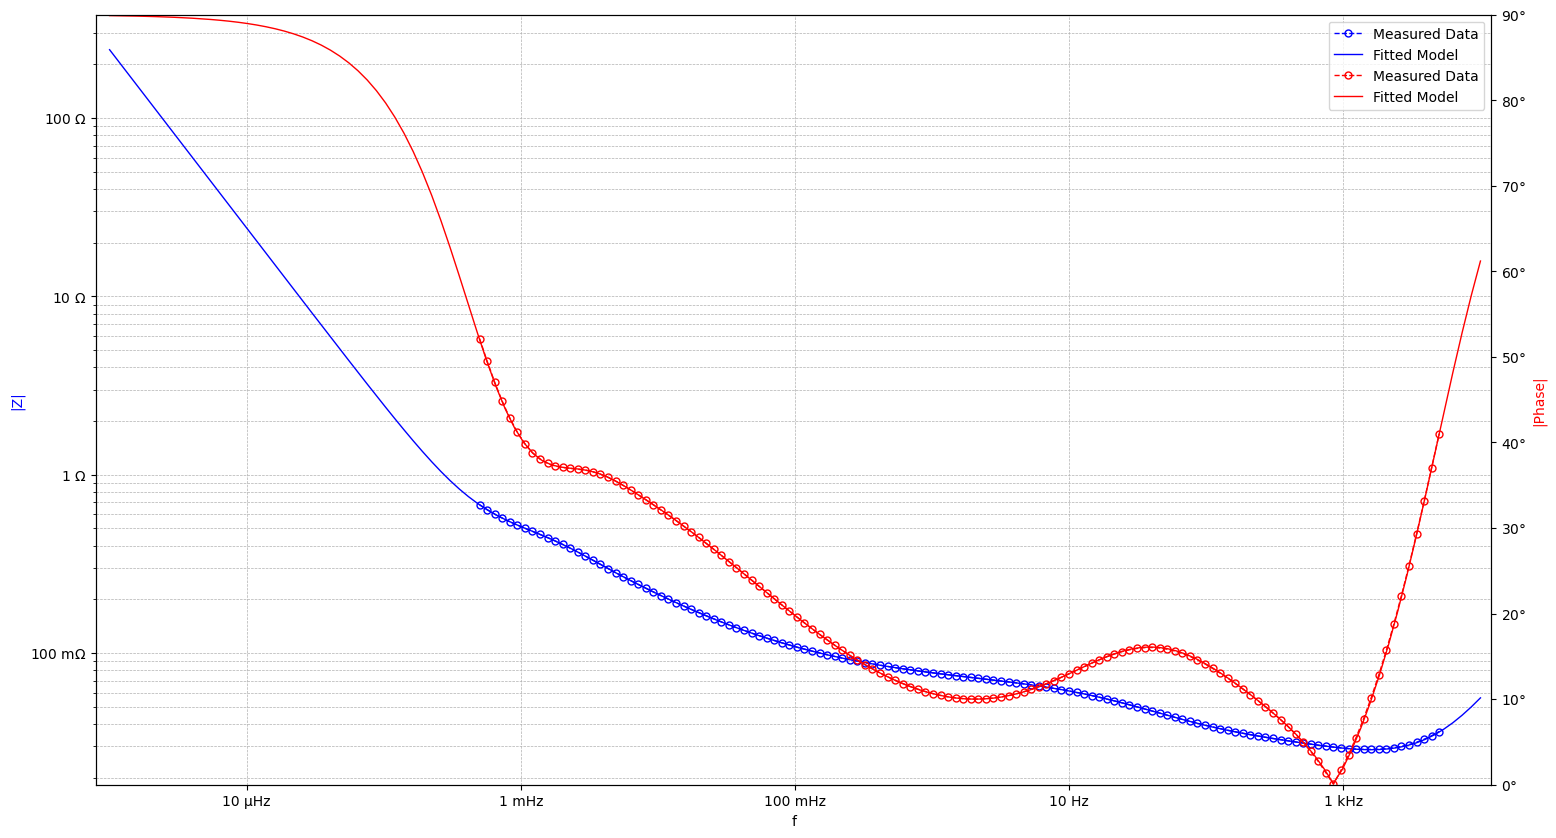

In [8]:
(fig2, (impedanceAxis2, phaseAxis2)) = EisFittingPlotter.plotBode(
    fittingResult, impedanceData
)
impedanceAxis2.legend(
    impedanceAxis2.get_lines() + phaseAxis2.get_lines(),
    2 * ["Measured Data", "Fitted Model"],
)
fig2.set_size_inches(18, 10)
plt.show()
fig2.savefig(f"{foldername}/bode_fitted.pdf")

# Optional Plotting Parameters

The two plotting methods also provide configuration options for other more frequently required plots.

With the parameter [zTogetherPhase](https://doc.zahner.de/zahner_analysis/analyze/index.html?highlight=ztogether#zahner_analysis.analysis_tools.eis_fitting.EisFittingPlotter.plotBode) it is determined whether phase and impedance are plotted in one figure or separately and with [absPhase](https://doc.zahner.de/zahner_analysis/analyze/index.html?highlight=ztogether#zahner_analysis.analysis_tools.eis_fitting.EisFittingPlotter.plotBode) it is determined whether the phase is displayed as an absolute value.

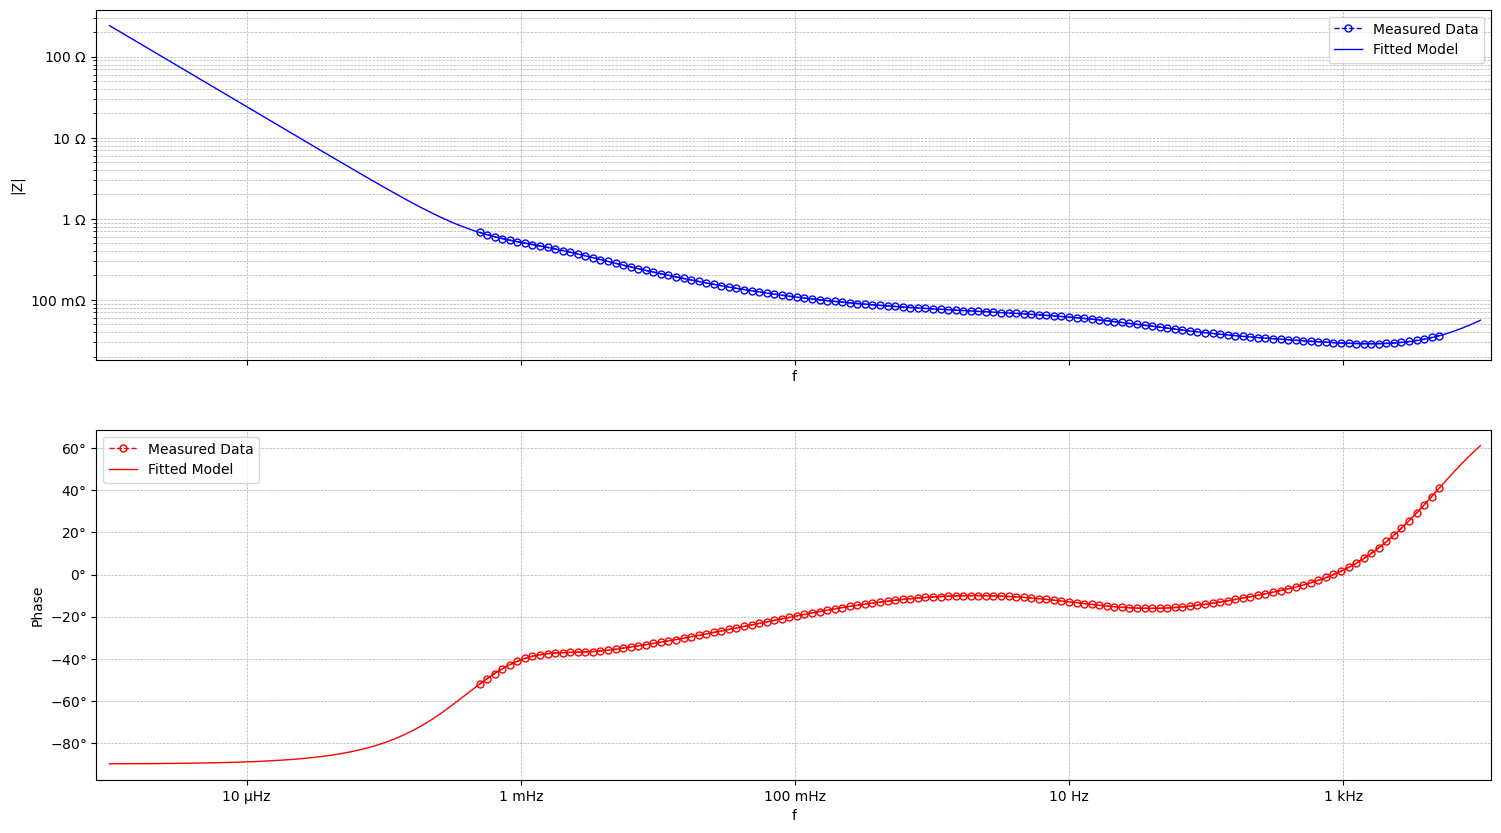

In [9]:
(fig3, (impedanceAxis3, phaseAxis3)) = EisFittingPlotter.plotBode(
    fittingResult, impedanceData, zTogetherPhase=False, absPhase=False
)
impedanceAxis3.legend(["Measured Data", "Fitted Model"])
phaseAxis3.legend(["Measured Data", "Fitted Model"])
fig3.set_size_inches(18, 10)
plt.show()
fig3.savefig(f"{foldername}/bode.svg")

The [Nyquist plot](https://doc.zahner.de/zahner_analysis/analyze/index.html?highlight=ztogether#zahner_analysis.analysis_tools.eis_fitting.EisFittingPlotter.plotNyquist) can be changed with the parameter [minusNyquist](https://doc.zahner.de/zahner_analysis/analyze/index.html?highlight=ztogether#zahner_analysis.analysis_tools.eis_fitting.EisFittingPlotter.plotNyquist) so that it is not displayed as default minus Nyquist. And with [maximumAbsImpedance](https://doc.zahner.de/zahner_analysis/analyze/index.html?highlight=ztogether#zahner_analysis.analysis_tools.eis_fitting.EisFittingPlotter.plotNyquist) the impedance up to which points are plotted can be set, for example to remove inductive components.

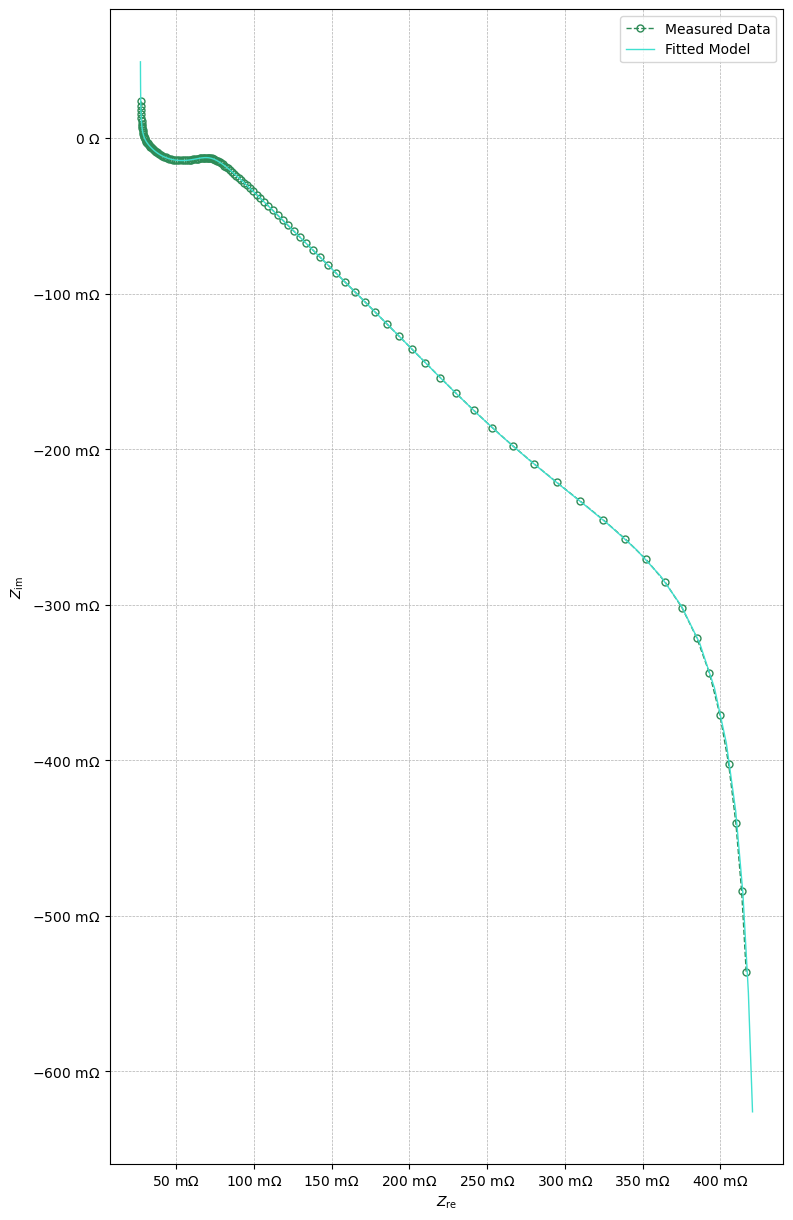

In [10]:
(fig4, ax) = EisFittingPlotter.plotNyquist(
    fittingResult, impedanceData, minusNyquist=False, maximumAbsImpedance=0.8
)
ax.legend(["Measured Data", "Fitted Model"])
fig4.set_size_inches(15, 15)
plt.show()

fig4.savefig(f"{foldername}/nyquist.jpg")

# Access of the data from the EisFittingResult object

From the [fit()](https://doc.zahner.de/zahner_analysis/analyze/index.html#zahner_analysis.analysis_tools.eis_fitting.EisFitting.fit) method an [EisFittingResult](https://doc.zahner.de/zahner_analysis/analyze/index.html#zahner_analysis.analysis_tools.eis_fitting.EisFittingResult) object is returned, which contains the results.

From this object a [JSON](https://en.wikipedia.org/wiki/JSON) object or string with the fit result can be read ([getFitResultJson()](https://doc.zahner.de/zahner_analysis/analyze/index.html?highlight=eisfittingresult#zahner_analysis.analysis_tools.eis_fitting.EisFittingResult.getFitResultJson)). Then a model with the fitted circuit elements can be read ([getFittedModel()](https://doc.zahner.de/zahner_analysis/analyze/index.html?highlight=eisfittingresult#zahner_analysis.analysis_tools.eis_fitting.EisFittingResult.getFittedModel)) and an impedance object with the simulated model ([getFittedSimulatedData()](https://doc.zahner.de/zahner_analysis/analyze/index.html?highlight=eisfittingresult#zahner_analysis.analysis_tools.eis_fitting.EisFittingResult.getFittedSimulatedData)). Likewise, an impedance object can be read with the samples used for the fit ([getFitInputData()](https://doc.zahner.de/zahner_analysis/analyze/index.html?highlight=eisfittingresult#zahner_analysis.analysis_tools.eis_fitting.EisFittingResult.getFitInputData)).

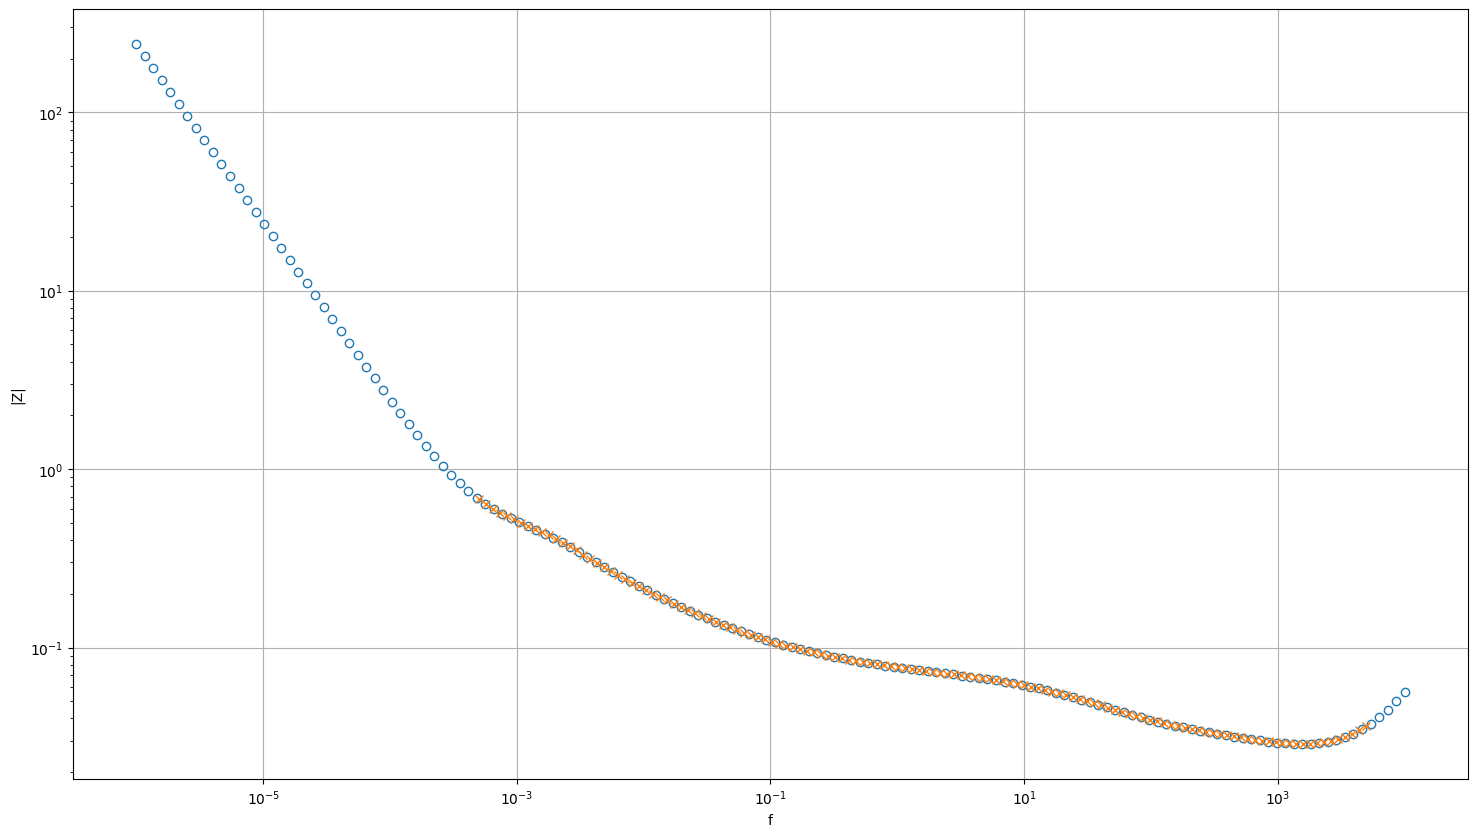

In [11]:
simulated = fittingResult.getFittedSimulatedData()

fig5, (axis) = plt.subplots(1, 1)
axis.loglog(
    simulated.getFrequencyArray(),
    simulated.getImpedanceArray(),
    marker="o",
    linewidth=0,
    fillstyle="none",
)
axis.loglog(
    impedanceData.getFrequencyArray(),
    impedanceData.getImpedanceArray(),
    marker="x",
    linewidth=0,
    fillstyle="none",
)
axis.grid("both")
axis.set_xlabel(r"f")
axis.set_ylabel(r"|Z|")
fig5.set_size_inches(18, 10)
plt.show()